# ANN-to-SNN conversion - MLP

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/ANN2SNN.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/ANN2SNN.ipynb)

This notebook demonstrates how to transform a fully-connected neural network trained using tensorflow/keras into an SNN network usable in ANNarchy.

The methods are adapted from the original models used in:

> Diehl et al. (2015) "Fast-classifying, high-accuracy spiking deep networks through weight and threshold balancing" Proceedings of IJCNN. doi: 10.1109/IJCNN.2015.7280696

In [1]:
#!pip install ANNarchy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(f"Tensorflow {tf.__version__}")

2026-01-05 13:47:55.565472: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-05 13:47:55.567856: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-05 13:47:55.576830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767617275.592134  120261 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767617275.596719  120261 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-05 13:47:55.611751: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Tensorflow 2.18.0


First we need to download and process the MNIST dataset provided by tensorflow.

In [3]:
# Download data
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()

# Normalize inputs
X_train = X_train.reshape(X_train.shape[0], 784).astype('float32') / 255.
X_test = X_test.reshape(X_test.shape[0], 784).astype('float32') / 255.

# One-hot output vectors
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

## Training an ANN in tensorflow/keras

The `tensorflow.keras` network is build using the functional API. 

The fully-connected network has two fully connected layers with ReLU, **no bias**, dropout at 0.5, and a softmax output layer with 10 neurons. We use the standard SGD optimizer and the categorical crossentropy loss for classification.

In [4]:
def create_mlp():
    # Model
    inputs = tf.keras.layers.Input(shape=(784,))
    x= tf.keras.layers.Dense(128, use_bias=False, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x= tf.keras.layers.Dense(128, use_bias=False, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(10, use_bias=False, activation='softmax')(x)

    model= tf.keras.Model(inputs, x)

    # Optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

    # Loss function
    model.compile(
        loss='categorical_crossentropy', # loss function
        optimizer=optimizer, # learning rule
        metrics=['accuracy'] # show accuracy
    )
    print(model.summary())

    return model

We can now train the network and save the weights in the HDF5 format.

In [5]:
# Create model
model = create_mlp()

# Train model
history = model.fit(
    X_train, T_train,       # training data
    batch_size=128,          # batch size
    epochs=20,              # Maximum number of epochs
    validation_split=0.1,   # Percentage of training data used for validation
)

model.save("runs/mlp.keras")

# Test model
predictions_keras = model.predict(X_test, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, T_test, verbose=0)
print(f"Test accuracy: {test_accuracy}")

W0000 00:00:1767617277.238554  120261 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,016 (461.00 KB)

 Trainable params: 118,016 (461.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


2026-01-05 13:47:57.342668: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


  1/422 ━━━━━━━━━━━━━━━━━━━━ 2:17 327ms/step - accuracy: 0.0938 - loss: 2.5156

  4/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0994 - loss: 2.5008

 28/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1424 - loss: 2.3581

 29/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1442 - loss: 2.3539

 54/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1849 - loss: 2.2660

 55/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1865 - loss: 2.2627

 81/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2263 - loss: 2.1781

107/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2604 - loss: 2.1003

108/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2616 - loss: 2.0946

135/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2923 - loss: 2.0225

161/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3184 - loss: 1.9562

162/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3194 - loss: 1.9514

188/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3424 - loss: 1.8942

189/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3432 - loss: 1.8920

216/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3645 - loss: 1.8360

217/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3652 - loss: 1.8340

245/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3849 - loss: 1.7817

272/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4021 - loss: 1.7358

299/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4178 - loss: 1.6937

325/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4318 - loss: 1.6561

326/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4323 - loss: 1.6547

352/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4452 - loss: 1.6199

378/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4572 - loss: 1.5875

404/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4684 - loss: 1.5572

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4761 - loss: 1.5363 - val_accuracy: 0.9158 - val_loss: 0.3259


Epoch 2/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8281 - loss: 0.5780

 26/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8183 - loss: 0.6324 

 54/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8183 - loss: 0.6237

 82/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8180 - loss: 0.6206

 83/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8180 - loss: 0.6204

111/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8185 - loss: 0.6157

140/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8187 - loss: 0.6127

169/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8190 - loss: 0.6093

170/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8190 - loss: 0.6091

199/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8194 - loss: 0.6063

200/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8194 - loss: 0.6062

228/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8200 - loss: 0.6033

229/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8200 - loss: 0.6032

258/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8206 - loss: 0.6004

259/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8207 - loss: 0.6004

286/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8213 - loss: 0.5979

313/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8219 - loss: 0.5955

341/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8225 - loss: 0.5933

366/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8231 - loss: 0.5914

392/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8237 - loss: 0.5893

417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8243 - loss: 0.5873

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8244 - loss: 0.5868 - val_accuracy: 0.9348 - val_loss: 0.2325


Epoch 3/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8750 - loss: 0.4475

  2/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.4299 

 28/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8575 - loss: 0.4557

 53/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8573 - loss: 0.4656

 54/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8573 - loss: 0.4658

 80/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8577 - loss: 0.4701

105/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8578 - loss: 0.4715

131/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8581 - loss: 0.4718

132/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8581 - loss: 0.4718

158/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8584 - loss: 0.4715

185/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8588 - loss: 0.4705

186/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8588 - loss: 0.4705

212/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8592 - loss: 0.4693

238/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8596 - loss: 0.4683

239/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8596 - loss: 0.4682

264/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8599 - loss: 0.4672

289/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8602 - loss: 0.4663

315/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8605 - loss: 0.4655

341/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8607 - loss: 0.4646

342/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8607 - loss: 0.4645

368/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8610 - loss: 0.4636

394/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.4626

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8616 - loss: 0.4617

419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8616 - loss: 0.4617

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8616 - loss: 0.4615 - val_accuracy: 0.9427 - val_loss: 0.1960


Epoch 4/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9062 - loss: 0.3988

 27/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.4315 

 28/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - loss: 0.4315

 54/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8694 - loss: 0.4346

 81/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8701 - loss: 0.4320

107/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8709 - loss: 0.4293

134/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.4268

160/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8728 - loss: 0.4242

186/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8736 - loss: 0.4217

211/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8743 - loss: 0.4198

212/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8743 - loss: 0.4198

238/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8749 - loss: 0.4180

239/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.4179

265/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8755 - loss: 0.4165

266/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8755 - loss: 0.4165

292/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8760 - loss: 0.4153

318/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8763 - loss: 0.4144

319/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8763 - loss: 0.4143

345/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8767 - loss: 0.4136

370/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8770 - loss: 0.4128

371/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8770 - loss: 0.4128

396/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8773 - loss: 0.4120

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8776 - loss: 0.4113 - val_accuracy: 0.9502 - val_loss: 0.1728


Epoch 5/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9141 - loss: 0.2683

 26/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8938 - loss: 0.3643 

 54/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8918 - loss: 0.3684

 81/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - loss: 0.3711

 82/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8908 - loss: 0.3712

109/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8903 - loss: 0.3735

136/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8901 - loss: 0.3749

163/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8900 - loss: 0.3751

189/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8902 - loss: 0.3742

190/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8902 - loss: 0.3742

217/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8903 - loss: 0.3733

243/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8905 - loss: 0.3725

269/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8907 - loss: 0.3717

296/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - loss: 0.3709

322/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8911 - loss: 0.3702

347/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8913 - loss: 0.3696

348/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8913 - loss: 0.3696

375/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8915 - loss: 0.3690

401/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8917 - loss: 0.3685

402/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8917 - loss: 0.3685

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8918 - loss: 0.3680 - val_accuracy: 0.9540 - val_loss: 0.1566


Epoch 6/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8828 - loss: 0.3283

  2/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8867 - loss: 0.3212 

 27/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8877 - loss: 0.3659

 28/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8879 - loss: 0.3659

 54/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8904 - loss: 0.3668

 55/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8905 - loss: 0.3667

 82/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8924 - loss: 0.3633

108/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8934 - loss: 0.3608

109/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8935 - loss: 0.3608

136/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8944 - loss: 0.3584

137/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8945 - loss: 0.3584

164/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8952 - loss: 0.3563

191/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8959 - loss: 0.3545

192/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8959 - loss: 0.3543

218/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8966 - loss: 0.3529

219/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8966 - loss: 0.3528

244/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8971 - loss: 0.3516

245/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8971 - loss: 0.3516

270/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8976 - loss: 0.3504

295/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8979 - loss: 0.3493

320/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8983 - loss: 0.3483

345/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8986 - loss: 0.3474

370/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8989 - loss: 0.3465

397/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8991 - loss: 0.3457

398/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8991 - loss: 0.3457

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8994 - loss: 0.3449 - val_accuracy: 0.9572 - val_loss: 0.1472


Epoch 7/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9219 - loss: 0.3495

 27/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9126 - loss: 0.3071 

 53/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9128 - loss: 0.3051

 54/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9127 - loss: 0.3052

 80/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9120 - loss: 0.3051

 81/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9120 - loss: 0.3051

106/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9116 - loss: 0.3050

132/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9113 - loss: 0.3047

155/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9111 - loss: 0.3049

181/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9108 - loss: 0.3051

207/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9106 - loss: 0.3055

208/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9106 - loss: 0.3055

233/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9104 - loss: 0.3060

234/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9104 - loss: 0.3060

259/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9102 - loss: 0.3063

260/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9102 - loss: 0.3063

285/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9101 - loss: 0.3065

286/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9101 - loss: 0.3065

312/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9100 - loss: 0.3066

339/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9099 - loss: 0.3068

366/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9099 - loss: 0.3070

392/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9099 - loss: 0.3071

417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9099 - loss: 0.3073

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9099 - loss: 0.3073 - val_accuracy: 0.9625 - val_loss: 0.1319


Epoch 8/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9062 - loss: 0.3145

 25/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9063 - loss: 0.3300 

 49/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9086 - loss: 0.3216

 74/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9096 - loss: 0.3164

 75/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9096 - loss: 0.3162

101/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9103 - loss: 0.3123

102/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9104 - loss: 0.3121

127/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9108 - loss: 0.3099

152/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9113 - loss: 0.3080

153/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9113 - loss: 0.3080

177/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9117 - loss: 0.3065

178/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9117 - loss: 0.3064

203/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9120 - loss: 0.3054

228/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9122 - loss: 0.3042

254/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9125 - loss: 0.3031

255/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9125 - loss: 0.3031

281/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9127 - loss: 0.3023

306/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9128 - loss: 0.3015

331/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9130 - loss: 0.3009

358/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9132 - loss: 0.3003

359/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9132 - loss: 0.3002

385/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9133 - loss: 0.2998

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9134 - loss: 0.2993

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9134 - loss: 0.2991 - val_accuracy: 0.9658 - val_loss: 0.1267


Epoch 9/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9297 - loss: 0.1641

 26/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9277 - loss: 0.2583 

 27/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9277 - loss: 0.2586

 54/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9258 - loss: 0.2675

 55/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9257 - loss: 0.2678

 82/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9237 - loss: 0.2729

 83/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9237 - loss: 0.2730

111/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9220 - loss: 0.2767

112/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9220 - loss: 0.2768

139/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9210 - loss: 0.2786

140/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9209 - loss: 0.2786

167/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9202 - loss: 0.2800

168/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9202 - loss: 0.2801

194/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9199 - loss: 0.2806

220/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9196 - loss: 0.2811

246/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9193 - loss: 0.2813

247/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9193 - loss: 0.2813

273/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9191 - loss: 0.2813

300/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9189 - loss: 0.2813

302/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9189 - loss: 0.2813

326/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9188 - loss: 0.2813

352/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9187 - loss: 0.2812

353/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9187 - loss: 0.2812

379/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9187 - loss: 0.2812

380/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9187 - loss: 0.2812

407/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9186 - loss: 0.2812

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9186 - loss: 0.2812

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9186 - loss: 0.2812 - val_accuracy: 0.9662 - val_loss: 0.1223


Epoch 10/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9141 - loss: 0.2579

  2/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.2691 

 28/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9088 - loss: 0.2768

 56/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9122 - loss: 0.2780

 57/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9123 - loss: 0.2778

 85/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9146 - loss: 0.2755

112/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9160 - loss: 0.2733

113/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9161 - loss: 0.2732

140/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9170 - loss: 0.2716

167/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9177 - loss: 0.2705

195/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9183 - loss: 0.2696

196/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9183 - loss: 0.2696

221/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9186 - loss: 0.2691

222/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9186 - loss: 0.2691

249/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9189 - loss: 0.2689

275/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9191 - loss: 0.2687

301/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9194 - loss: 0.2685

302/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9194 - loss: 0.2684

328/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9196 - loss: 0.2683

329/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9196 - loss: 0.2683

353/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9198 - loss: 0.2682

378/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9198 - loss: 0.2682

379/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9199 - loss: 0.2682

380/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9199 - loss: 0.2682

405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9200 - loss: 0.2681

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9200 - loss: 0.2682 - val_accuracy: 0.9678 - val_loss: 0.1169


Epoch 11/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9141 - loss: 0.2586

 26/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9312 - loss: 0.2390 

 51/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9296 - loss: 0.2418

 52/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9295 - loss: 0.2419

 78/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9283 - loss: 0.2446

105/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9270 - loss: 0.2477

133/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9262 - loss: 0.2504

160/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9259 - loss: 0.2518

187/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9256 - loss: 0.2529

188/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9256 - loss: 0.2529

214/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9254 - loss: 0.2535

241/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9253 - loss: 0.2541

268/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9251 - loss: 0.2548

294/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9250 - loss: 0.2556

320/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9248 - loss: 0.2563

321/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9248 - loss: 0.2563

349/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9247 - loss: 0.2568

376/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9247 - loss: 0.2572

402/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9246 - loss: 0.2575

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9246 - loss: 0.2577 - val_accuracy: 0.9683 - val_loss: 0.1125


Epoch 12/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9141 - loss: 0.4034

  2/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9199 - loss: 0.3629 

 28/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9235 - loss: 0.2972

 54/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9241 - loss: 0.2869

 80/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9236 - loss: 0.2828

107/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9236 - loss: 0.2792

134/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9238 - loss: 0.2760

161/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9242 - loss: 0.2730

162/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9242 - loss: 0.2729

189/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9246 - loss: 0.2705

214/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9248 - loss: 0.2689

215/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9248 - loss: 0.2688

243/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9250 - loss: 0.2672

269/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9252 - loss: 0.2659

270/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9252 - loss: 0.2659

297/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9253 - loss: 0.2647

298/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9253 - loss: 0.2647

323/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9254 - loss: 0.2638

349/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9255 - loss: 0.2630

375/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9256 - loss: 0.2622

401/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9257 - loss: 0.2616

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9258 - loss: 0.2612 - val_accuracy: 0.9693 - val_loss: 0.1074


Epoch 13/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9297 - loss: 0.2320

 25/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9247 - loss: 0.2466 

 50/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9238 - loss: 0.2506

 75/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9251 - loss: 0.2499

101/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9258 - loss: 0.2494

126/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9266 - loss: 0.2485

151/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9271 - loss: 0.2478

152/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9271 - loss: 0.2477

178/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9276 - loss: 0.2470

204/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9278 - loss: 0.2466

230/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9280 - loss: 0.2465

231/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9280 - loss: 0.2465

257/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9280 - loss: 0.2467

284/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9280 - loss: 0.2469

310/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9281 - loss: 0.2470

338/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9281 - loss: 0.2471

364/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9282 - loss: 0.2471

365/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9282 - loss: 0.2471

366/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9282 - loss: 0.2471

393/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9283 - loss: 0.2470

394/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9283 - loss: 0.2470

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9284 - loss: 0.2469

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9284 - loss: 0.2469 - val_accuracy: 0.9713 - val_loss: 0.1021


Epoch 14/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9219 - loss: 0.2012

 26/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9373 - loss: 0.2376 

 53/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9370 - loss: 0.2354

 81/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9364 - loss: 0.2338

 82/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9364 - loss: 0.2337

109/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9362 - loss: 0.2323

136/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9356 - loss: 0.2323

162/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9353 - loss: 0.2322

188/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9350 - loss: 0.2318

213/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9349 - loss: 0.2315

238/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9348 - loss: 0.2314

263/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9346 - loss: 0.2315

290/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9344 - loss: 0.2317

315/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9343 - loss: 0.2318

316/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9342 - loss: 0.2318

341/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9341 - loss: 0.2319

342/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9341 - loss: 0.2319

370/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9339 - loss: 0.2322

398/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9337 - loss: 0.2324

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9336 - loss: 0.2326 - val_accuracy: 0.9710 - val_loss: 0.1041


Epoch 15/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9453 - loss: 0.2200

  2/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9395 - loss: 0.2321 

 29/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9274 - loss: 0.2644

 30/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9275 - loss: 0.2641

 56/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9278 - loss: 0.2569

 82/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9279 - loss: 0.2536

110/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9280 - loss: 0.2513

111/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9280 - loss: 0.2512

139/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9281 - loss: 0.2488

166/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9283 - loss: 0.2470

194/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9286 - loss: 0.2455

195/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9286 - loss: 0.2454

222/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9288 - loss: 0.2443

249/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9290 - loss: 0.2433

250/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9290 - loss: 0.2432

276/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9292 - loss: 0.2423

303/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9295 - loss: 0.2414

304/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9295 - loss: 0.2413

331/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9297 - loss: 0.2405

357/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9299 - loss: 0.2397

358/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9299 - loss: 0.2396

385/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9300 - loss: 0.2390

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9301 - loss: 0.2384

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9301 - loss: 0.2383

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9302 - loss: 0.2381 - val_accuracy: 0.9718 - val_loss: 0.0983


Epoch 16/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9844 - loss: 0.0926

 26/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9325 - loss: 0.2142 

 27/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9323 - loss: 0.2145

 53/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9311 - loss: 0.2158

 80/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9319 - loss: 0.2141

106/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9324 - loss: 0.2142

133/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9326 - loss: 0.2152

160/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9327 - loss: 0.2165

186/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9327 - loss: 0.2174

213/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9329 - loss: 0.2179

214/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9329 - loss: 0.2179

240/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9331 - loss: 0.2181

265/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9333 - loss: 0.2182

266/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9333 - loss: 0.2182

292/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9335 - loss: 0.2184

293/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9335 - loss: 0.2185

318/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9336 - loss: 0.2187

319/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9336 - loss: 0.2187

345/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9338 - loss: 0.2189

371/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9339 - loss: 0.2191

372/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9339 - loss: 0.2192

398/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9340 - loss: 0.2193

399/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9340 - loss: 0.2193

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9341 - loss: 0.2194 - val_accuracy: 0.9715 - val_loss: 0.0976


Epoch 17/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9141 - loss: 0.1960

 27/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9272 - loss: 0.2164 

 28/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9274 - loss: 0.2163

 55/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9309 - loss: 0.2161

 81/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9321 - loss: 0.2182

 82/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9321 - loss: 0.2183

108/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9328 - loss: 0.2198

109/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9328 - loss: 0.2198

136/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9334 - loss: 0.2202

164/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9338 - loss: 0.2209

191/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9340 - loss: 0.2214

217/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9343 - loss: 0.2215

243/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9345 - loss: 0.2213

244/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9345 - loss: 0.2213

271/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9348 - loss: 0.2210

272/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9348 - loss: 0.2210

299/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9350 - loss: 0.2208

325/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9352 - loss: 0.2206

352/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9354 - loss: 0.2204

378/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9355 - loss: 0.2202

403/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9356 - loss: 0.2199

404/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9356 - loss: 0.2199

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9357 - loss: 0.2198 - val_accuracy: 0.9737 - val_loss: 0.0942


Epoch 18/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9297 - loss: 0.2046

 28/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9403 - loss: 0.1925 

 56/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9418 - loss: 0.1933

 57/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9419 - loss: 0.1934

 85/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9416 - loss: 0.1971

 86/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9416 - loss: 0.1972

113/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9412 - loss: 0.2002

114/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9412 - loss: 0.2002

141/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9408 - loss: 0.2022

168/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9406 - loss: 0.2033

195/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9404 - loss: 0.2042

196/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9404 - loss: 0.2043

223/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9402 - loss: 0.2052

250/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9400 - loss: 0.2062

276/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9398 - loss: 0.2071

303/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9396 - loss: 0.2079

304/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9396 - loss: 0.2079

331/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9395 - loss: 0.2084

358/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9394 - loss: 0.2089

384/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.2092

409/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.2094

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.2095

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9392 - loss: 0.2096 - val_accuracy: 0.9748 - val_loss: 0.0913


Epoch 19/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9688 - loss: 0.1111

 26/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9472 - loss: 0.1837 

 27/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9470 - loss: 0.1842

 53/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9439 - loss: 0.1896

 80/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9421 - loss: 0.1938

 81/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9420 - loss: 0.1940

108/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9408 - loss: 0.1983

134/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9401 - loss: 0.2011

161/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9396 - loss: 0.2030

162/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9396 - loss: 0.2031

189/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.2043

190/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.2043

218/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9392 - loss: 0.2051

245/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9392 - loss: 0.2056

246/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9392 - loss: 0.2056

272/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.2058

298/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.2059

300/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.2059

326/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9394 - loss: 0.2059

352/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9394 - loss: 0.2060

353/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9394 - loss: 0.2060

380/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9394 - loss: 0.2061

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9394 - loss: 0.2061

407/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9394 - loss: 0.2061

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9395 - loss: 0.2060 - val_accuracy: 0.9740 - val_loss: 0.0925


Epoch 20/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9453 - loss: 0.2159

 26/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9358 - loss: 0.2080 

 27/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9357 - loss: 0.2081

 54/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9360 - loss: 0.2116

 80/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9362 - loss: 0.2111

 81/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9363 - loss: 0.2111

107/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9366 - loss: 0.2107

133/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9368 - loss: 0.2107

160/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9370 - loss: 0.2105

161/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9370 - loss: 0.2105

188/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9372 - loss: 0.2102

189/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9372 - loss: 0.2102

217/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9374 - loss: 0.2100

244/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.2097

245/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9376 - loss: 0.2097

272/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9377 - loss: 0.2095

299/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9378 - loss: 0.2092

326/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9379 - loss: 0.2091

327/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9379 - loss: 0.2091

353/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9380 - loss: 0.2089

354/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9380 - loss: 0.2089

381/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9381 - loss: 0.2088

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9382 - loss: 0.2086

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9383 - loss: 0.2085 - val_accuracy: 0.9747 - val_loss: 0.0900


Test accuracy: 0.964900016784668


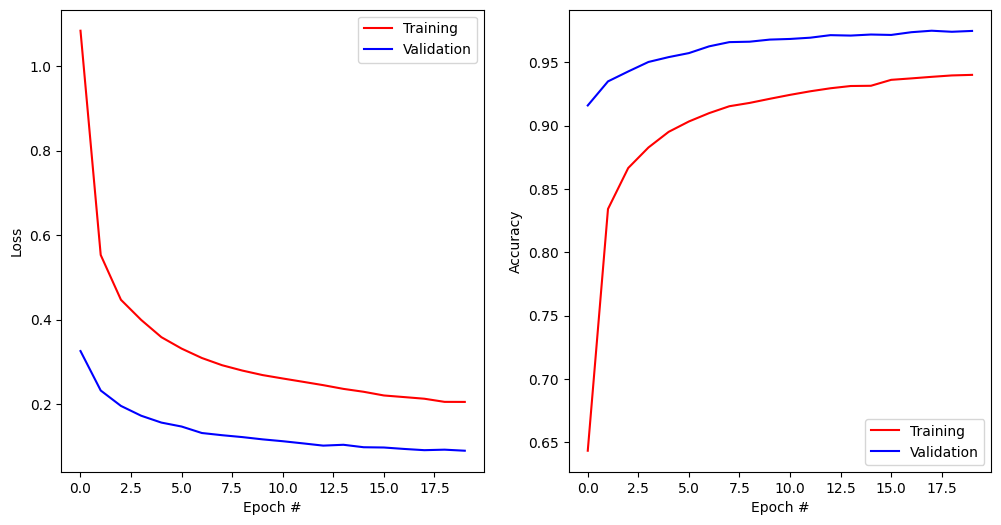

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Initialize the ANN-to-SNN converter

We first create an instance of the ANN-to-SNN conversion object. The function receives the *input_encoding* parameter, which is the type of input encoding we want to use. 

By default, there are *intrinsically bursting* (`IB`), *phase shift oscillation* (`PSO`) and *Poisson* (`poisson`) available.

In [7]:
from ANNarchy.extensions.ann_to_snn_conversion import ANNtoSNNConverter

snn_converter = ANNtoSNNConverter(
    input_encoding='IB', 
    hidden_neuron='IaF',
    read_out='spike_count',
)

ANNarchy 5.0 (5.0.0) on linux (posix).


After that, we provide the TensorFlow model stored as a `.keras` file to the conversion tool. The print-out of the network structure of the imported network is suppressed when `show_info=False` is provided to `load_keras_model`.

In [8]:
net = snn_converter.load_keras_model("runs/mlp.keras", show_info=True)

* Input layer: input_layer, (784,)
* InputLayer skipped.
* Dense layer: dense, 128 
    weights: (128, 784)
    mean -0.0036564269103109837, std 0.05264626443386078
    min -0.3581183850765228, max 0.2122010588645935
* Dropout skipped.
* Dense layer: dense_1, 128 
    weights: (128, 128)
    mean 0.003981234040111303, std 0.10197019577026367
    min -0.28383105993270874, max 0.3577111065387726
* Dropout skipped.
* Dense layer: dense_2, 10 
    weights: (10, 128)
    mean -0.0034574796445667744, std 0.2152443379163742
    min -0.5003451108932495, max 0.4554655849933624



When the network has been built successfully, we can perform a test using all MNIST training samples. Using `duration_per_sample`, the duration simulated for each image can be specified. Here, 200 ms seem to be enough.

In [9]:
predictions_snn = snn_converter.predict(X_test, duration_per_sample=200)

  0%|                                                                                       | 0/10000 [00:00<?, ?it/s]

  0%|▎                                                                            | 45/10000 [00:00<00:22, 443.15it/s]

  1%|▋                                                                            | 90/10000 [00:00<00:22, 435.76it/s]

  1%|█                                                                           | 134/10000 [00:00<00:22, 430.34it/s]

  2%|█▎                                                                          | 178/10000 [00:00<00:22, 428.00it/s]

  2%|█▋                                                                          | 221/10000 [00:00<00:23, 416.51it/s]

  3%|█▉                                                                          | 263/10000 [00:00<00:24, 395.42it/s]

  3%|██▎                                                                         | 303/10000 [00:00<00:24, 391.72it/s]

  3%|██▌                                                                         | 344/10000 [00:00<00:24, 393.91it/s]

  4%|██▉                                                                         | 387/10000 [00:00<00:23, 402.31it/s]

  4%|███▎                                                                        | 431/10000 [00:01<00:23, 411.42it/s]

  5%|███▌                                                                        | 473/10000 [00:01<00:23, 410.64it/s]

  5%|███▉                                                                        | 517/10000 [00:01<00:22, 418.16it/s]

  6%|████▎                                                                       | 561/10000 [00:01<00:22, 422.45it/s]

  6%|████▌                                                                       | 604/10000 [00:01<00:22, 421.87it/s]

  6%|████▉                                                                       | 648/10000 [00:01<00:21, 425.11it/s]

  7%|█████▎                                                                      | 691/10000 [00:01<00:22, 418.95it/s]

  7%|█████▌                                                                      | 733/10000 [00:01<00:22, 418.53it/s]

  8%|█████▉                                                                      | 776/10000 [00:01<00:21, 421.33it/s]

  8%|██████▏                                                                     | 819/10000 [00:01<00:21, 423.37it/s]

  9%|██████▌                                                                     | 864/10000 [00:02<00:21, 430.87it/s]

  9%|██████▉                                                                     | 908/10000 [00:02<00:21, 417.45it/s]

 10%|███████▏                                                                    | 951/10000 [00:02<00:21, 421.07it/s]

 10%|███████▌                                                                    | 994/10000 [00:02<00:21, 416.52it/s]

 10%|███████▊                                                                   | 1036/10000 [00:02<00:21, 410.07it/s]

 11%|████████                                                                   | 1078/10000 [00:02<00:22, 401.93it/s]

 11%|████████▍                                                                  | 1119/10000 [00:02<00:22, 394.68it/s]

 12%|████████▋                                                                  | 1162/10000 [00:02<00:21, 403.09it/s]

 12%|█████████                                                                  | 1203/10000 [00:02<00:21, 403.82it/s]

 12%|█████████▎                                                                 | 1244/10000 [00:03<00:22, 387.55it/s]

 13%|█████████▌                                                                 | 1283/10000 [00:03<00:23, 374.72it/s]

 13%|█████████▉                                                                 | 1326/10000 [00:03<00:22, 387.74it/s]

 14%|██████████▎                                                                | 1368/10000 [00:03<00:21, 396.72it/s]

 14%|██████████▌                                                                | 1410/10000 [00:03<00:21, 401.35it/s]

 15%|██████████▉                                                                | 1453/10000 [00:03<00:20, 407.22it/s]

 15%|███████████▏                                                               | 1495/10000 [00:03<00:20, 408.93it/s]

 15%|███████████▌                                                               | 1536/10000 [00:03<00:21, 395.05it/s]

 16%|███████████▊                                                               | 1576/10000 [00:03<00:22, 375.09it/s]

 16%|████████████                                                               | 1614/10000 [00:03<00:22, 366.21it/s]

 17%|████████████▍                                                              | 1651/10000 [00:04<00:22, 365.44it/s]

 17%|████████████▋                                                              | 1692/10000 [00:04<00:22, 375.63it/s]

 17%|████████████▉                                                              | 1731/10000 [00:04<00:21, 378.15it/s]

 18%|█████████████▎                                                             | 1769/10000 [00:04<00:22, 374.00it/s]

 18%|█████████████▌                                                             | 1808/10000 [00:04<00:21, 375.75it/s]

 18%|█████████████▊                                                             | 1848/10000 [00:04<00:21, 380.14it/s]

 19%|██████████████▏                                                            | 1887/10000 [00:04<00:21, 381.93it/s]

 19%|██████████████▍                                                            | 1926/10000 [00:04<00:21, 378.47it/s]

 20%|██████████████▋                                                            | 1964/10000 [00:04<00:21, 377.08it/s]

 20%|███████████████                                                            | 2002/10000 [00:05<00:21, 372.69it/s]

 20%|███████████████▎                                                           | 2041/10000 [00:05<00:21, 375.97it/s]

 21%|███████████████▌                                                           | 2079/10000 [00:05<00:21, 374.30it/s]

 21%|███████████████▉                                                           | 2117/10000 [00:05<00:21, 368.08it/s]

 22%|████████████████▏                                                          | 2155/10000 [00:05<00:21, 369.60it/s]

 22%|████████████████▍                                                          | 2198/10000 [00:05<00:20, 386.03it/s]

 22%|████████████████▊                                                          | 2241/10000 [00:05<00:19, 398.28it/s]

 23%|█████████████████                                                          | 2281/10000 [00:05<00:19, 389.39it/s]

 23%|█████████████████▍                                                         | 2323/10000 [00:05<00:19, 397.91it/s]

 24%|█████████████████▋                                                         | 2365/10000 [00:05<00:18, 403.63it/s]

 24%|██████████████████                                                         | 2406/10000 [00:06<00:19, 389.05it/s]

 24%|██████████████████▎                                                        | 2448/10000 [00:06<00:19, 395.97it/s]

 25%|██████████████████▋                                                        | 2488/10000 [00:06<00:18, 396.84it/s]

 25%|██████████████████▉                                                        | 2528/10000 [00:06<00:19, 391.14it/s]

 26%|███████████████████▎                                                       | 2570/10000 [00:06<00:18, 398.52it/s]

 26%|███████████████████▌                                                       | 2613/10000 [00:06<00:18, 405.41it/s]

 27%|███████████████████▉                                                       | 2654/10000 [00:06<00:18, 405.90it/s]

 27%|████████████████████▏                                                      | 2698/10000 [00:06<00:17, 414.05it/s]

 27%|████████████████████▌                                                      | 2741/10000 [00:06<00:17, 417.13it/s]

 28%|████████████████████▊                                                      | 2783/10000 [00:06<00:17, 414.33it/s]

 28%|█████████████████████▏                                                     | 2825/10000 [00:07<00:17, 414.34it/s]

 29%|█████████████████████▌                                                     | 2867/10000 [00:07<00:17, 411.65it/s]

 29%|█████████████████████▊                                                     | 2909/10000 [00:07<00:17, 411.17it/s]

 30%|██████████████████████▏                                                    | 2953/10000 [00:07<00:16, 416.55it/s]

 30%|██████████████████████▍                                                    | 2996/10000 [00:07<00:16, 420.41it/s]

 30%|██████████████████████▊                                                    | 3039/10000 [00:07<00:16, 420.48it/s]

 31%|███████████████████████                                                    | 3082/10000 [00:07<00:16, 416.86it/s]

 31%|███████████████████████▍                                                   | 3124/10000 [00:07<00:16, 417.36it/s]

 32%|███████████████████████▊                                                   | 3167/10000 [00:07<00:16, 419.50it/s]

 32%|████████████████████████                                                   | 3209/10000 [00:07<00:16, 416.51it/s]

 33%|████████████████████████▍                                                  | 3252/10000 [00:08<00:16, 418.29it/s]

 33%|████████████████████████▋                                                  | 3294/10000 [00:08<00:16, 417.10it/s]

 33%|█████████████████████████                                                  | 3336/10000 [00:08<00:16, 411.55it/s]

 34%|█████████████████████████▎                                                 | 3378/10000 [00:08<00:16, 396.10it/s]

 34%|█████████████████████████▋                                                 | 3418/10000 [00:08<00:16, 393.97it/s]

 35%|█████████████████████████▉                                                 | 3458/10000 [00:08<00:16, 390.33it/s]

 35%|██████████████████████████▏                                                | 3498/10000 [00:08<00:17, 377.40it/s]

 35%|██████████████████████████▌                                                | 3536/10000 [00:08<00:17, 368.54it/s]

 36%|██████████████████████████▊                                                | 3574/10000 [00:08<00:17, 371.37it/s]

 36%|███████████████████████████                                                | 3612/10000 [00:09<00:17, 370.87it/s]

 36%|███████████████████████████▍                                               | 3650/10000 [00:09<00:17, 369.18it/s]

 37%|███████████████████████████▋                                               | 3687/10000 [00:09<00:17, 365.77it/s]

 37%|███████████████████████████▉                                               | 3724/10000 [00:09<00:17, 363.67it/s]

 38%|████████████████████████████▏                                              | 3761/10000 [00:09<00:17, 363.62it/s]

 38%|████████████████████████████▍                                              | 3798/10000 [00:09<00:17, 361.38it/s]

 38%|████████████████████████████▊                                              | 3835/10000 [00:09<00:17, 356.53it/s]

 39%|█████████████████████████████                                              | 3871/10000 [00:09<00:17, 353.12it/s]

 39%|█████████████████████████████▎                                             | 3907/10000 [00:09<00:17, 352.81it/s]

 39%|█████████████████████████████▌                                             | 3943/10000 [00:09<00:17, 352.09it/s]

 40%|█████████████████████████████▊                                             | 3979/10000 [00:10<00:17, 351.72it/s]

 40%|██████████████████████████████                                             | 4015/10000 [00:10<00:16, 352.32it/s]

 41%|██████████████████████████████▍                                            | 4053/10000 [00:10<00:16, 358.05it/s]

 41%|██████████████████████████████▋                                            | 4089/10000 [00:10<00:16, 354.52it/s]

 41%|██████████████████████████████▉                                            | 4125/10000 [00:10<00:16, 354.14it/s]

 42%|███████████████████████████████▏                                           | 4161/10000 [00:10<00:16, 351.52it/s]

 42%|███████████████████████████████▌                                           | 4200/10000 [00:10<00:15, 362.59it/s]

 42%|███████████████████████████████▊                                           | 4237/10000 [00:10<00:16, 359.34it/s]

 43%|████████████████████████████████                                           | 4277/10000 [00:10<00:15, 369.30it/s]

 43%|████████████████████████████████▎                                          | 4316/10000 [00:11<00:15, 372.83it/s]

 44%|████████████████████████████████▋                                          | 4354/10000 [00:11<00:15, 371.54it/s]

 44%|████████████████████████████████▉                                          | 4392/10000 [00:11<00:15, 367.27it/s]

 44%|█████████████████████████████████▏                                         | 4429/10000 [00:11<00:15, 366.62it/s]

 45%|█████████████████████████████████▍                                         | 4466/10000 [00:11<00:15, 364.61it/s]

 45%|█████████████████████████████████▊                                         | 4503/10000 [00:11<00:15, 363.07it/s]

 45%|██████████████████████████████████                                         | 4540/10000 [00:11<00:15, 361.33it/s]

 46%|██████████████████████████████████▎                                        | 4577/10000 [00:11<00:15, 360.67it/s]

 46%|██████████████████████████████████▌                                        | 4614/10000 [00:11<00:14, 359.54it/s]

 46%|██████████████████████████████████▉                                        | 4650/10000 [00:11<00:14, 358.71it/s]

 47%|███████████████████████████████████▏                                       | 4687/10000 [00:12<00:14, 360.11it/s]

 47%|███████████████████████████████████▍                                       | 4724/10000 [00:12<00:14, 358.42it/s]

 48%|███████████████████████████████████▋                                       | 4763/10000 [00:12<00:14, 364.91it/s]

 48%|████████████████████████████████████                                       | 4800/10000 [00:12<00:14, 363.74it/s]

 48%|████████████████████████████████████▎                                      | 4837/10000 [00:12<00:14, 360.84it/s]

 49%|████████████████████████████████████▌                                      | 4875/10000 [00:12<00:14, 363.48it/s]

 49%|████████████████████████████████████▊                                      | 4912/10000 [00:12<00:14, 358.54it/s]

 49%|█████████████████████████████████████                                      | 4948/10000 [00:12<00:14, 355.69it/s]

 50%|█████████████████████████████████████▍                                     | 4986/10000 [00:12<00:13, 361.24it/s]

 50%|█████████████████████████████████████▋                                     | 5027/10000 [00:12<00:13, 373.87it/s]

 51%|██████████████████████████████████████                                     | 5067/10000 [00:13<00:13, 378.99it/s]

 51%|██████████████████████████████████████▎                                    | 5107/10000 [00:13<00:12, 384.45it/s]

 51%|██████████████████████████████████████▌                                    | 5146/10000 [00:13<00:12, 385.79it/s]

 52%|██████████████████████████████████████▉                                    | 5186/10000 [00:13<00:12, 389.33it/s]

 52%|███████████████████████████████████████▏                                   | 5229/10000 [00:13<00:11, 399.02it/s]

 53%|███████████████████████████████████████▌                                   | 5270/10000 [00:13<00:11, 400.48it/s]

 53%|███████████████████████████████████████▊                                   | 5311/10000 [00:13<00:12, 385.00it/s]

 54%|████████████████████████████████████████▏                                  | 5352/10000 [00:13<00:11, 390.24it/s]

 54%|████████████████████████████████████████▍                                  | 5392/10000 [00:13<00:11, 392.10it/s]

 54%|████████████████████████████████████████▋                                  | 5433/10000 [00:13<00:11, 396.87it/s]

 55%|█████████████████████████████████████████                                  | 5473/10000 [00:14<00:11, 396.12it/s]

 55%|█████████████████████████████████████████▎                                 | 5513/10000 [00:14<00:11, 396.48it/s]

 56%|█████████████████████████████████████████▋                                 | 5555/10000 [00:14<00:11, 400.44it/s]

 56%|█████████████████████████████████████████▉                                 | 5596/10000 [00:14<00:11, 380.38it/s]

 56%|██████████████████████████████████████████▎                                | 5637/10000 [00:14<00:11, 387.31it/s]

 57%|██████████████████████████████████████████▌                                | 5677/10000 [00:14<00:11, 390.19it/s]

 57%|██████████████████████████████████████████▉                                | 5719/10000 [00:14<00:10, 397.30it/s]

 58%|███████████████████████████████████████████▏                               | 5760/10000 [00:14<00:10, 398.86it/s]

 58%|███████████████████████████████████████████▌                               | 5801/10000 [00:14<00:10, 401.68it/s]

 58%|███████████████████████████████████████████▊                               | 5842/10000 [00:15<00:10, 402.37it/s]

 59%|████████████████████████████████████████████                               | 5883/10000 [00:15<00:10, 400.64it/s]

 59%|████████████████████████████████████████████▍                              | 5924/10000 [00:15<00:10, 402.07it/s]

 60%|████████████████████████████████████████████▋                              | 5965/10000 [00:15<00:10, 395.84it/s]

 60%|█████████████████████████████████████████████                              | 6005/10000 [00:15<00:10, 388.19it/s]

 60%|█████████████████████████████████████████████▎                             | 6047/10000 [00:15<00:09, 396.31it/s]

 61%|█████████████████████████████████████████████▋                             | 6087/10000 [00:15<00:10, 389.07it/s]

 61%|█████████████████████████████████████████████▉                             | 6126/10000 [00:15<00:10, 379.73it/s]

 62%|██████████████████████████████████████████████▏                            | 6165/10000 [00:15<00:10, 363.92it/s]

 62%|██████████████████████████████████████████████▌                            | 6202/10000 [00:16<00:10, 347.21it/s]

 62%|██████████████████████████████████████████████▊                            | 6243/10000 [00:16<00:10, 362.65it/s]

 63%|███████████████████████████████████████████████                            | 6283/10000 [00:16<00:09, 372.69it/s]

 63%|███████████████████████████████████████████████▍                           | 6322/10000 [00:16<00:09, 377.52it/s]

 64%|███████████████████████████████████████████████▋                           | 6360/10000 [00:16<00:09, 373.34it/s]

 64%|████████████████████████████████████████████████                           | 6401/10000 [00:16<00:09, 383.24it/s]

 64%|████████████████████████████████████████████████▎                          | 6442/10000 [00:16<00:09, 389.30it/s]

 65%|████████████████████████████████████████████████▌                          | 6482/10000 [00:16<00:08, 391.05it/s]

 65%|████████████████████████████████████████████████▉                          | 6522/10000 [00:16<00:08, 390.96it/s]

 66%|█████████████████████████████████████████████████▎                         | 6567/10000 [00:16<00:08, 407.40it/s]

 66%|█████████████████████████████████████████████████▌                         | 6614/10000 [00:17<00:07, 424.38it/s]

 67%|█████████████████████████████████████████████████▉                         | 6659/10000 [00:17<00:07, 429.97it/s]

 67%|██████████████████████████████████████████████████▎                        | 6703/10000 [00:17<00:07, 430.70it/s]

 67%|██████████████████████████████████████████████████▌                        | 6747/10000 [00:17<00:07, 417.78it/s]

 68%|██████████████████████████████████████████████████▉                        | 6789/10000 [00:17<00:07, 407.32it/s]

 68%|███████████████████████████████████████████████████▏                       | 6831/10000 [00:17<00:07, 408.63it/s]

 69%|███████████████████████████████████████████████████▌                       | 6872/10000 [00:17<00:07, 403.07it/s]

 69%|███████████████████████████████████████████████████▊                       | 6916/10000 [00:17<00:07, 412.03it/s]

 70%|████████████████████████████████████████████████████▏                      | 6958/10000 [00:17<00:07, 411.77it/s]

 70%|████████████████████████████████████████████████████▌                      | 7000/10000 [00:17<00:07, 409.44it/s]

 70%|████████████████████████████████████████████████████▊                      | 7042/10000 [00:18<00:07, 409.91it/s]

 71%|█████████████████████████████████████████████████████▏                     | 7084/10000 [00:18<00:07, 410.66it/s]

 71%|█████████████████████████████████████████████████████▍                     | 7126/10000 [00:18<00:06, 411.12it/s]

 72%|█████████████████████████████████████████████████████▊                     | 7168/10000 [00:18<00:06, 408.71it/s]

 72%|██████████████████████████████████████████████████████                     | 7209/10000 [00:18<00:06, 406.87it/s]

 73%|██████████████████████████████████████████████████████▍                    | 7253/10000 [00:18<00:06, 416.49it/s]

 73%|██████████████████████████████████████████████████████▋                    | 7295/10000 [00:18<00:06, 416.42it/s]

 73%|███████████████████████████████████████████████████████                    | 7337/10000 [00:18<00:06, 412.67it/s]

 74%|███████████████████████████████████████████████████████▎                   | 7379/10000 [00:18<00:06, 409.64it/s]

 74%|███████████████████████████████████████████████████████▋                   | 7422/10000 [00:18<00:06, 414.51it/s]

 75%|████████████████████████████████████████████████████████                   | 7468/10000 [00:19<00:05, 425.39it/s]

 75%|████████████████████████████████████████████████████████▎                  | 7513/10000 [00:19<00:05, 429.69it/s]

 76%|████████████████████████████████████████████████████████▋                  | 7556/10000 [00:19<00:05, 425.28it/s]

 76%|████████████████████████████████████████████████████████▉                  | 7599/10000 [00:19<00:05, 416.69it/s]

 76%|█████████████████████████████████████████████████████████▎                 | 7642/10000 [00:19<00:05, 418.02it/s]

 77%|█████████████████████████████████████████████████████████▋                 | 7685/10000 [00:19<00:05, 421.34it/s]

 77%|█████████████████████████████████████████████████████████▉                 | 7729/10000 [00:19<00:05, 425.75it/s]

 78%|██████████████████████████████████████████████████████████▎                | 7772/10000 [00:19<00:05, 407.64it/s]

 78%|██████████████████████████████████████████████████████████▌                | 7813/10000 [00:19<00:05, 396.72it/s]

 79%|██████████████████████████████████████████████████████████▉                | 7853/10000 [00:20<00:05, 388.88it/s]

 79%|███████████████████████████████████████████████████████████▏               | 7892/10000 [00:20<00:05, 382.25it/s]

 79%|███████████████████████████████████████████████████████████▍               | 7931/10000 [00:20<00:05, 373.59it/s]

 80%|███████████████████████████████████████████████████████████▊               | 7970/10000 [00:20<00:05, 378.18it/s]

 80%|████████████████████████████████████████████████████████████               | 8008/10000 [00:20<00:05, 374.94it/s]

 80%|████████████████████████████████████████████████████████████▎              | 8046/10000 [00:20<00:05, 373.28it/s]

 81%|████████████████████████████████████████████████████████████▋              | 8085/10000 [00:20<00:05, 377.33it/s]

 81%|████████████████████████████████████████████████████████████▉              | 8125/10000 [00:20<00:04, 382.01it/s]

 82%|█████████████████████████████████████████████████████████████▏             | 8166/10000 [00:20<00:04, 389.92it/s]

 82%|█████████████████████████████████████████████████████████████▌             | 8208/10000 [00:20<00:04, 395.56it/s]

 82%|█████████████████████████████████████████████████████████████▊             | 8249/10000 [00:21<00:04, 399.59it/s]

 83%|██████████████████████████████████████████████████████████████▏            | 8291/10000 [00:21<00:04, 405.53it/s]

 83%|██████████████████████████████████████████████████████████████▍            | 8333/10000 [00:21<00:04, 409.15it/s]

 84%|██████████████████████████████████████████████████████████████▊            | 8374/10000 [00:21<00:03, 409.15it/s]

 84%|███████████████████████████████████████████████████████████████            | 8416/10000 [00:21<00:03, 409.72it/s]

 85%|███████████████████████████████████████████████████████████████▍           | 8458/10000 [00:21<00:03, 411.73it/s]

 85%|███████████████████████████████████████████████████████████████▊           | 8500/10000 [00:21<00:03, 395.84it/s]

 85%|████████████████████████████████████████████████████████████████           | 8540/10000 [00:21<00:03, 392.93it/s]

 86%|████████████████████████████████████████████████████████████████▎          | 8582/10000 [00:21<00:03, 398.73it/s]

 86%|████████████████████████████████████████████████████████████████▋          | 8625/10000 [00:21<00:03, 406.97it/s]

 87%|█████████████████████████████████████████████████████████████████          | 8668/10000 [00:22<00:03, 413.32it/s]

 87%|█████████████████████████████████████████████████████████████████▎         | 8710/10000 [00:22<00:03, 408.88it/s]

 88%|█████████████████████████████████████████████████████████████████▋         | 8751/10000 [00:22<00:03, 401.44it/s]

 88%|█████████████████████████████████████████████████████████████████▉         | 8792/10000 [00:22<00:03, 392.88it/s]

 88%|██████████████████████████████████████████████████████████████████▏        | 8832/10000 [00:22<00:03, 388.97it/s]

 89%|██████████████████████████████████████████████████████████████████▌        | 8871/10000 [00:22<00:02, 387.98it/s]

 89%|██████████████████████████████████████████████████████████████████▊        | 8911/10000 [00:22<00:02, 390.49it/s]

 90%|███████████████████████████████████████████████████████████████████▏       | 8952/10000 [00:22<00:02, 392.88it/s]

 90%|███████████████████████████████████████████████████████████████████▍       | 8992/10000 [00:22<00:02, 393.90it/s]

 90%|███████████████████████████████████████████████████████████████████▋       | 9032/10000 [00:23<00:02, 394.66it/s]

 91%|████████████████████████████████████████████████████████████████████       | 9072/10000 [00:23<00:02, 391.65it/s]

 91%|████████████████████████████████████████████████████████████████████▎      | 9112/10000 [00:23<00:02, 379.81it/s]

 92%|████████████████████████████████████████████████████████████████████▋      | 9151/10000 [00:23<00:02, 378.14it/s]

 92%|████████████████████████████████████████████████████████████████████▉      | 9189/10000 [00:23<00:02, 376.72it/s]

 92%|█████████████████████████████████████████████████████████████████████▏     | 9227/10000 [00:23<00:02, 373.71it/s]

 93%|█████████████████████████████████████████████████████████████████████▍     | 9265/10000 [00:23<00:01, 368.79it/s]

 93%|█████████████████████████████████████████████████████████████████████▊     | 9303/10000 [00:23<00:01, 371.21it/s]

 93%|██████████████████████████████████████████████████████████████████████     | 9344/10000 [00:23<00:01, 381.83it/s]

 94%|██████████████████████████████████████████████████████████████████████▍    | 9386/10000 [00:23<00:01, 391.74it/s]

 94%|██████████████████████████████████████████████████████████████████████▋    | 9427/10000 [00:24<00:01, 395.07it/s]

 95%|███████████████████████████████████████████████████████████████████████    | 9469/10000 [00:24<00:01, 399.73it/s]

 95%|███████████████████████████████████████████████████████████████████████▎   | 9510/10000 [00:24<00:01, 400.87it/s]

 96%|███████████████████████████████████████████████████████████████████████▋   | 9551/10000 [00:24<00:01, 396.83it/s]

 96%|███████████████████████████████████████████████████████████████████████▉   | 9591/10000 [00:24<00:01, 397.05it/s]

 96%|████████████████████████████████████████████████████████████████████████▎  | 9634/10000 [00:24<00:00, 405.29it/s]

 97%|████████████████████████████████████████████████████████████████████████▌  | 9679/10000 [00:24<00:00, 416.83it/s]

 97%|████████████████████████████████████████████████████████████████████████▉  | 9721/10000 [00:24<00:00, 416.01it/s]

 98%|█████████████████████████████████████████████████████████████████████████▏ | 9763/10000 [00:24<00:00, 411.80it/s]

 98%|█████████████████████████████████████████████████████████████████████████▌ | 9805/10000 [00:24<00:00, 405.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████▊ | 9848/10000 [00:25<00:00, 412.62it/s]

 99%|██████████████████████████████████████████████████████████████████████████▏| 9894/10000 [00:25<00:00, 425.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████▌| 9937/10000 [00:25<00:00, 425.94it/s]

100%|██████████████████████████████████████████████████████████████████████████▊| 9980/10000 [00:25<00:00, 426.61it/s]

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.10it/s]

Using the recorded predictions, we can now compute the accuracy using scikit-learn for all presented samples.

In [10]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(t_test, predictions_snn))
print("Test accuracy of the SNN:", accuracy_score(t_test, predictions_snn))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.94      0.96       982
           5       0.97      0.95      0.96       892
           6       0.96      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.96      0.95      0.95       974
           9       0.94      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Test accuracy of the SNN: 0.9625


For comparison, here is the performance of the original ANN in keras:

In [11]:
print(classification_report(t_test, predictions_keras.argmax(axis=1)))
print("Test accuracy of the ANN:", accuracy_score(t_test, predictions_keras.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.96      0.95      0.96       982
           5       0.97      0.94      0.95       892
           6       0.96      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.97      0.96      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Test accuracy of the ANN: 0.9649
